# Backtesting: EW vs CW

In [1]:
import numpy as np
import pandas as pd

import edhec_risk_kit_204 as erk

%load_ext autoreload
%autoreload 2
ind49_rets = erk.get_ind_returns(weighting="vw", n_inds=49)["1974":]
ind49_mcap = erk.get_ind_market_caps(49, weights=True)["1974":]


In this section we'll develop a basic infrastructure to backtest various portfolio construction techniques and compare them. Here we'll start with something quite simple and straightforward - we'll write trivially simple weight-optimizers for Equally Weighted and Cap Weighted portfolios and compare them. Obviously, there are no Covariance estimates required for either one of these weighting schemes. In following sessions we'll enhance these optimizers to use more complex weighting schemes that will rely on covariance estimates.

In [2]:
def weight_ew(r):
    """
    Returns the weights of the EW portfolio based on the asset returns "r" as a DataFrame
    """
    n = len(r.columns)
    return pd.Series(1/n, index=r.columns)

def backtest_ws(r, estimation_window=60, weighting=weight_ew):
    """
    Backtests a given weighting scheme, given some parameters:
    r : asset returns to use to build the portfolio
    estimation_window: the window to use to estimate parameters
    weighting: the weighting scheme to use, must be a function that takes "r", and a variable number of keyword-value arguments
    """
    n_periods = r.shape[0]
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window+1)]
    # windows is a list of tuples which gives us the (integer) location of the start and stop (non inclusive)
    # for each estimation window
    weights = [weighting(r.iloc[win[0]:win[1]]) for win in windows]
    # List -> DataFrame
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window-1:].index, columns=r.columns)
    # return weights
    returns = (weights * r).sum(axis="columns",  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return returns

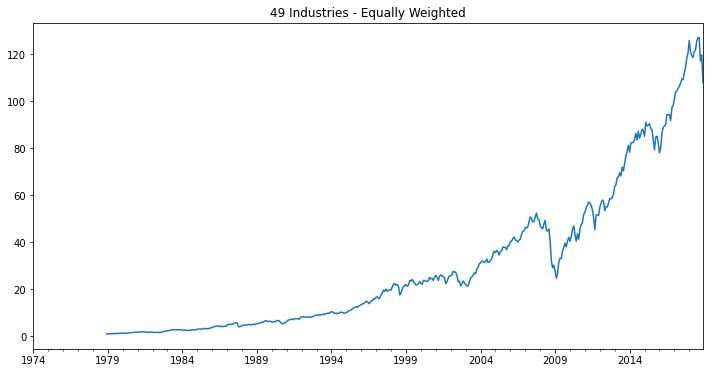

In [3]:
ewr = backtest_ws(ind49_rets, weighting=weight_ew)
ewi = (1+ewr).cumprod()
ewi.plot(figsize=(12,6), title="49 Industries - Equally Weighted");

Now, let's add capweighting. We'll need to compute capweights, which we've already been provided through the marketcap file. We can refactor the code we've developed in the past to add a convenience function to our toolkit. Note the use of `**kwargs` to be able to take a variable number of keyword arguments to the function so that we can call any weighting function and let that weighting function take care of whatever arguments it needs. We'll have to refactor `weight_ew` with this new signature, but thats the only change (for now) for `weight_ew`.

In [4]:
def weight_ew(r, **kwargs):
    """
    Returns the weights of the EW portfolio based on the asset returns "r" as a DataFrame
    """
    n = len(r.columns)
    return pd.Series(1/n, index=r.columns)

def weight_cw(r, cap_weights, **kwargs):
    """
    Returns the weights of the CW portfolio based on the time series of capweights
    """
    return cap_weights.loc[r.index[1]]

def backtest_ws(r, estimation_window=60, weighting=weight_ew, **kwargs):
    """
    Backtests a given weighting scheme, given some parameters:
    r : asset returns to use to build the portfolio
    estimation_window: the window to use to estimate parameters
    weighting: the weighting scheme to use, must be a function that takes "r", and a variable number of keyword-value arguments
    """
    n_periods = r.shape[0]
    # return windows
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window+1)]
    weights = [weighting(r.iloc[win[0]:win[1]], **kwargs) for win in windows]
    # convert list of weights to DataFrame
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window-1:].index, columns=r.columns)
    # return weights
    returns = (weights * r).sum(axis="columns",  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return returns

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.123921,0.160660,-0.759092,6.659028,0.071404,0.102331,0.568799,-0.528292
CW,0.119761,0.147661,-0.726933,5.621768,0.065773,0.093909,0.591491,-0.516647


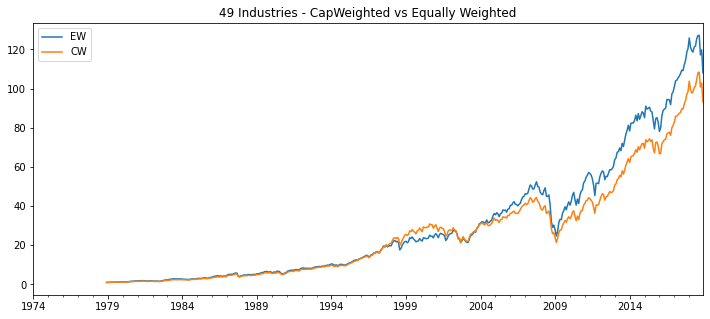

In [5]:
ewr = backtest_ws(ind49_rets)
cwr = backtest_ws(ind49_rets, weighting=weight_cw, cap_weights=ind49_mcap)
btr = pd.DataFrame({"EW": ewr, "CW": cwr})
(1+btr).cumprod().plot(figsize=(12,5), title="49 Industries - CapWeighted vs Equally Weighted")
erk.summary_stats(btr.dropna())

# Improving EW with CapWeight Tethering

Often in practice, we'll want to implement some sort of a modification of a pure strategy. For instance, although Equal Weight portfolios are popular, they'll be constrained in some way - for instance to match the sector weights of the cap-weighted benchmark or to make sure that microcap stocks are not overweighted. The motivation for doing so could be to make a portfolio more tradeable (e.g. some microcaps may not have the liquidity) or to improve the tracking error to the Cap-Weighted index.

As an illustration of how that can be achieved, we enhance our simple `weight_ew` allocator to (i) drop microcap stocks beyond a particular threshold, and (ii) impose a constraint that ensures that the maximum weight assigned to any stock is no more than some multiple of the weight it would be in a cap-weighted portfolio.


In [6]:
def weight_ew(r, cap_weights=None, max_cw_mult=None, microcap_threshold=None, **kwargs):
    """
    Returns the weights of the EW portfolio based on the asset returns "r" as a DataFrame
    If supplied a set of capweights and a capweight tether, it is applied and reweighted 
    """
    n = len(r.columns)
    ew = pd.Series(1/n, index=r.columns)
    if cap_weights is not None:
        cw = cap_weights.loc[r.index[0]] # starting cap weight
        ## exclude microcaps
        if microcap_threshold is not None and microcap_threshold > 0:
            microcap = cw < microcap_threshold
            ew[microcap] = 0
            ew = ew/ew.sum()
        #limit weight to a multiple of capweight
        if max_cw_mult is not None and max_cw_mult > 0:
            ew = np.minimum(ew, cw*max_cw_mult)
            ew = ew/ew.sum() #reweight
    return ew

def weight_cw(r, cap_weights, **kwargs):
    """
    Returns the weights of the CW portfolio based on the time series of capweights
    """
    w = cap_weights.loc[r.index[1]]
    return w/w.sum()

def backtest_ws(r, estimation_window=60, weighting=weight_ew, **kwargs):
    """
    Backtests a given weighting scheme, given some parameters:
    r : asset returns to use to build the portfolio
    estimation_window: the window to use to estimate parameters
    weighting: the weighting scheme to use, must be a function that takes "r", and a variable number of keyword-value arguments
    """
    n_periods = r.shape[0]
    # return windows
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window+1)]
    weights = [weighting(r.iloc[win[0]:win[1]], **kwargs) for win in windows]
    # convert to DataFrame
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window-1:].index, columns=r.columns)
    returns = (weights * r).sum(axis="columns",  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return returns


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.123921,0.160660,-0.759092,6.659028,0.071404,0.102331,0.568799,-0.528292
EW-Tethered,0.125572,0.156923,-0.752967,6.187433,0.069778,0.099191,0.592597,-0.530654
CW,0.119761,0.147661,-0.726933,5.621768,0.065773,0.093909,0.591491,-0.516647


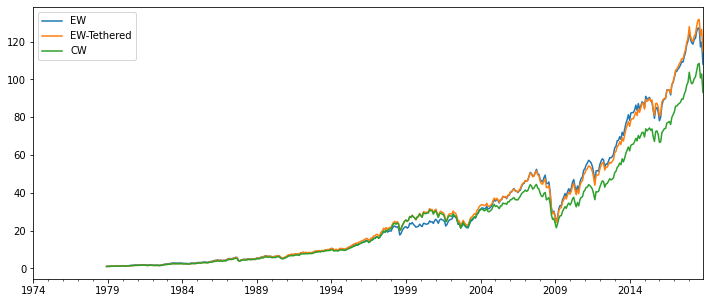

In [7]:
ewr = backtest_ws(ind49_rets)
ewtr = backtest_ws(ind49_rets, cap_weights=ind49_mcap, max_cw_mult=5, microcap_threshold=.005)
cwr = backtest_ws(ind49_rets, weighting=weight_cw, cap_weights=ind49_mcap)
btr = pd.DataFrame({"EW": ewr, "EW-Tethered": ewtr, "CW": cwr})
(1+btr).cumprod().plot(figsize=(12,5))
erk.summary_stats(btr.dropna())

Don't forget to add the code we've just developed to the toolkit, we're going to use it in future sessions!

## A Final Note ...

One of the motivations of adding the tethering constraint is to improve tracking error to the cap-weighted portfolio. Let's see if we did manage to achieve that:

In [8]:
erk.tracking_error(ewr, cwr),erk.tracking_error(ewtr, cwr)

(0.23248147494738433, 0.1553623086424526)